# Imports

In [16]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from torchvision.models import DenseNet121_Weights
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import datetime
from sklearn.metrics import f1_score
from PIL import Image
import nibabel as nib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualisation

In [17]:
def plot_graph(data):
    num_charts = len(data)
    ncols = 4
    nrows = (num_charts + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))
    axes = axes.flatten()

    for i, sublist in enumerate(data):
        sublist_data, start, end, filename = sublist
        x_indices = range(len(sublist_data))
        
        # Plot on the current axis
        axes[i].bar(x_indices, sublist_data, color='blue', alpha=0.7)
        # axes[i].axvline(x=start, color='red', linestyle='-', linewidth=1.5, label='Start')
        # axes[i].axvline(x=end, color='red', linestyle='-', linewidth=1.5, label='End')
        
        axes[i].set_title(f'{filename}', fontsize=12)
        axes[i].set_xlabel('Index', fontsize=10)
        axes[i].set_ylabel('Value', fontsize=10)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def view_nii_pic(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def visualize_photo(img: np.ndarray, photo_title: str, *slices: int) -> None:
    print(f"Visualizing {photo_title}")
    plt.figure(figsize=(5 * len(slices), 5)) 
    
    for i, slice_num in enumerate(slices):
        plt.subplot(1, len(slices), i + 1)
        plt.title(f"photo Slice {slice_num}")
        plt.imshow(img[:, :, slice_num], cmap="gray")
        
    plt.tight_layout() 
    plt.show()
  
    
def visualize_photos(original: np.ndarray, segmented: np.ndarray, reference: np.ndarray, *slices: int) -> None:
    num_slices = len(slices)
    plt.figure(figsize=(15, 5 * num_slices))  # Adjust figure size based on the number of slices

    for i, slice_num in enumerate(slices):
        # Original slice
        plt.subplot(num_slices, 3, 3 * i + 1)
        plt.title(f"Original Slice {slice_num}")
        plt.imshow(original[:, :, slice_num], cmap="gray")
        
        # Segmented slice
        plt.subplot(num_slices, 3, 3 * i + 2)
        plt.title(f"Segmented Slice {slice_num}")
        plt.imshow(segmented[:, :, slice_num], cmap="gray")
        
        # Reference slice
        plt.subplot(num_slices, 3, 3 * i + 3)
        plt.title(f"Reference Slice {slice_num}")
        plt.imshow(reference[:, :, slice_num], cmap="gray")

    plt.tight_layout() 
    plt.show()
    
def plot_histogram(img: np.ndarray) -> None:
    plt.hist(img.ravel(), bins=256, range=(img.min()+1, img.max()-1), fc='k', ec='k')
    plt.axvline(x=-320, color='red', linestyle='--', linewidth=1.5)
    plt.show()

# Dataset

In [18]:
class AbdomenDataset(Dataset):
    def __init__(self, filepath: str, label_filepath: str, transform=None):
        self.transform = transform
        self.data: list = self._load_nii_gz_files(filepath)
        self.labels: list = self._load_labels_file(label_filepath)
        
        self.frames_list: list = []
        self.labels_list: list = []
        
        self.positive_count = 0
        
        for file_name, img in self.data:
            print(f"loading {file_name}")
            end, begin = self.labels[file_name]
            for i in range(0, img.shape[2]):
                self.frames_list.append(img[:, :, i])
                self.labels_list.append(1 if begin <= i <= end else 0)
                self.positive_count += self.labels_list[-1]
                
        print(f"Loaded {len(self.frames_list)} frames")
        
    def __len__(self) -> int:
        return len(self.frames_list)
    
    def __getitem__(self, idx: int) -> dict:
        img = self.frames_list[idx]
        label = float(self.labels_list[idx])
        
        img = torch.tensor(img).float().unsqueeze(0)
        img = self.transform(img)            
        return img.repeat(3, 1, 1), label
        
        
    def _load_labels_file(self, label_filepath: str) -> dict:
        labels: list = {}
        with open(label_filepath, 'r') as file:
            for line in file:
                file_name, end, begin = line.split()
                labels[file_name] = (int(end), int(begin))
        return labels
    
    def _load_nii_gz_files(self, filepath) -> list:
        data: list = []
        for file_name in os.listdir(filepath):
            if file_name.endswith('.nii.gz'):
                file_path = os.path.join(filepath, file_name)
                nii_img = nib.load(file_path)
                nii_data = nii_img.get_fdata()  # img as numpy array
                data.append((file_name, nii_data))
        return data
    
    
class AbdomenSingleDataset(Dataset):
    def __init__(self, filepath: str, filename: str, transform=None):
        self.transform = transform
        self.original_img: list = self._load_file(filepath, filename)
        self.frames_list: list = [self.original_img[:, :, i] for i in range(self.original_img.shape[2])]
        print(f"Loaded {len(self.frames_list)} frames")
        
    def __len__(self) -> int:
        return len(self.frames_list)
    
    def __getitem__(self, idx: int) -> dict:
        img = self.frames_list[idx]
        img = torch.tensor(img).float().unsqueeze(0)
        img = self.transform(img)            
        return img.repeat(3, 1, 1)
    
    def _load_file(self, filepath: str, filename: str) -> list:   
        f = os.path.join(filepath, filename)
        nii_img = nib.load(f)
        nii_data = nii_img.get_fdata()
        return nii_data
    

# Model

In [19]:
class AbdomenModel(nn.Module):
    def __init__(self) -> None:
        super(AbdomenModel, self).__init__()
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        self.freeze_densenet()
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(self.densenet.classifier.in_features, 1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def predict(self, x):
        x = self(x)
        return self.sigmoid(x)
    
    def forward(self, x):
        return self.densenet(x)
    
    def unfreeze_densenet(self) -> None:
        for param in self.densenet.parameters():
            param.requires_grad = True
    
    def freeze_densenet(self) -> None:
        for param in self.densenet.parameters():
            param.requires_grad = False

# Training loop

In [20]:
def training_loop(model: AbdomenModel, criterion: torch.nn.Module, optimizer: Optimizer, dataloader: dict, EPOCHS: int = 10):
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    sigm = nn.Sigmoid()
    
    for epoch in range(EPOCHS):    
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for data in tqdm(dataloader['train']):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(dim=-1)
            outputs_sigm = sigm(outputs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            preds = (outputs_sigm > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(dataloader['train'])
        train_accuracy = correct / total
        loss_history.append(train_loss)
        accuracy_history.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in tqdm(dataloader['val']):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device).float()
                
                outputs = model(inputs).squeeze(dim=-1)
                outputs_sigm = sigm(outputs)
            
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = (outputs_sigm > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / len(dataloader['val'])
        val_accuracy = val_correct / val_total
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
    return model, [accuracy_history, loss_history, val_accuracy_history, val_loss_history]

# Train

In [ ]:
transform_val = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(40),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 2)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

datasets = {
    "train": AbdomenDataset('data/train', 'data/oznaczenia.txt', transform=transform),
    "val": AbdomenDataset('data/val', 'data/oznaczenia.txt', transform=transform_val),
}

dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=8, shuffle=True),
    "val": DataLoader(datasets["val"], batch_size=8, shuffle=True),
}

In [ ]:
scaling_weight = (len(datasets['train']) - datasets['train'].positive_count) / datasets['train'].positive_count

model = AbdomenModel().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling_weight], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model, history = training_loop(model, criterion, optimizer, dataloaders, EPOCHS=5)
model.unfreeze_densenet()
model, history = training_loop(model, criterion, optimizer, dataloaders, EPOCHS=7)
torch.save(model.state_dict(), f"results/model_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{max(history[2])}.pt")

# Test

## Select Abdomen Algorithm

In [25]:
def select_window_of_abdomen(list_of_probabilities: list) -> tuple[int, int]:
    epsilon = 1e-10
    log_proba = np.log(np.clip(list_of_probabilities, epsilon, 1))
    log_proba_rev = np.log(np.clip(1 - np.array(list_of_probabilities), epsilon, 1))
    
    best_begin = 0
    best_end = 0
    best_value = -np.inf
    
    for start in range(len(list_of_probabilities)):
        for end in range(start, len(list_of_probabilities)):
            sum_log = np.sum(log_proba[start:end+1])
            sum_rev_rest = np.sum(log_proba_rev[end + 1:]) + np.sum(log_proba_rev[:start])
            value = sum_log + sum_rev_rest
            
            if value > best_value:
                best_value = value
                best_begin = start
                best_end = end
                
    return best_begin, best_end
    

def naive_select_abdomen_window(list_of_probabilities: list) -> tuple[int, int]:
    size = 30
    
    max_value = float('-inf')
    left, right = 0, size
    
    for i in range(len(list_of_probabilities) - size):
        value = sum(list_of_probabilities[i:i + size])
        if value > max_value:
            max_value = value
            left, right = i, i + size
            
    return left, right
    

## Load data

In [26]:
def create_dataloaders(filepath: str) -> list:
    
    transform_val = torchvision.transforms.Compose([
    lambda x: (x + 1024) / 3072,
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

    dataloaders: list = []
    for file_name in os.listdir(filepath):
        if file_name.endswith('.nii.gz'):
            dataloader = DataLoader(AbdomenSingleDataset(filepath, file_name, transform=transform_val))
            dataloaders.append((dataloader, file_name))
    
    return dataloaders

def load_labeled_scores(label_filepath: str) -> dict:
        labels: list = {}
        with open(label_filepath, 'r') as file:
            for line in file:
                file_name, end, begin = line.split()
                labels[file_name] = (int(end), int(begin))
        return labels

## Run to evaluate all scores

In [27]:
def evaluate_model(filepath: str) -> list:
    model_path = 'results/model_2024-12-11_11-12-01_0.9933460076045627.pt'
    model = AbdomenModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    sigm = nn.Sigmoid()
    outputs = []
    dataloaders = create_dataloaders(filepath)

    for dataloader, file_name in dataloaders:
        dl_output = []
        for data in tqdm(dataloader):
            inputs = data
            inputs = inputs.to(device)
            fragment_outputs = model(inputs).squeeze(dim=-1)
            fragment_outputs_sigm = sigm(fragment_outputs)
            dl_output.append(fragment_outputs_sigm.tolist()[0])
        
        outputs.append((dl_output, file_name))
    
    return outputs

In [28]:
labeled_scores = load_labeled_scores('data/test/ranges.txt')
calculated_outputs = evaluate_model('data/test')

/tmp/ipykernel_1380/4215286586.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Loaded 57 frames
Loaded 54 frames
Loaded 56 frames
Loaded 57 frames
Loaded 53 frames
Loaded 174 frames
Loaded 57 frames
Loaded 98 frames
Loaded 48 frames
Loaded 53 frames


100%|██████████| 53/53 [00:01<00:00, 41.09it/s]


In [29]:
scores: list[int] = []
for output, file_name in calculated_outputs:
    label_end, label_start = labeled_scores[file_name]
    end, start = select_window_of_abdomen(output)
    print(f"start: {start}, end: {end}, label_start: {label_start}, label_end: {label_end}")
    score = abs(start - label_start) + abs(end - label_end)
    scores.append(score)
    print(f"{file_name} score: {score}")
    
print(f"=== Mean score: {np.mean(scores)} ===")


start: 42, end: 24, label_start: 49, label_end: 30
5.nii.gz score: 13
start: 46, end: 21, label_start: 47, label_end: 25
0.nii.gz score: 5
start: 45, end: 24, label_start: 46, label_end: 24
1.nii.gz score: 1
start: 45, end: 26, label_start: 46, label_end: 26
7.nii.gz score: 1
start: 39, end: 21, label_start: 46, label_end: 22
2.nii.gz score: 8
start: 83, end: 40, label_start: 86, label_end: 43
3.nii.gz score: 6
start: 44, end: 18, label_start: 44, label_end: 21
9.nii.gz score: 3
start: 89, end: 65, label_start: 87, label_end: 66
8.nii.gz score: 3
start: 34, end: 19, label_start: 38, label_end: 19
4.nii.gz score: 4
start: 43, end: 20, label_start: 43, label_end: 21
6.nii.gz score: 1
=== Mean score: 4.5 ===


## Plot results

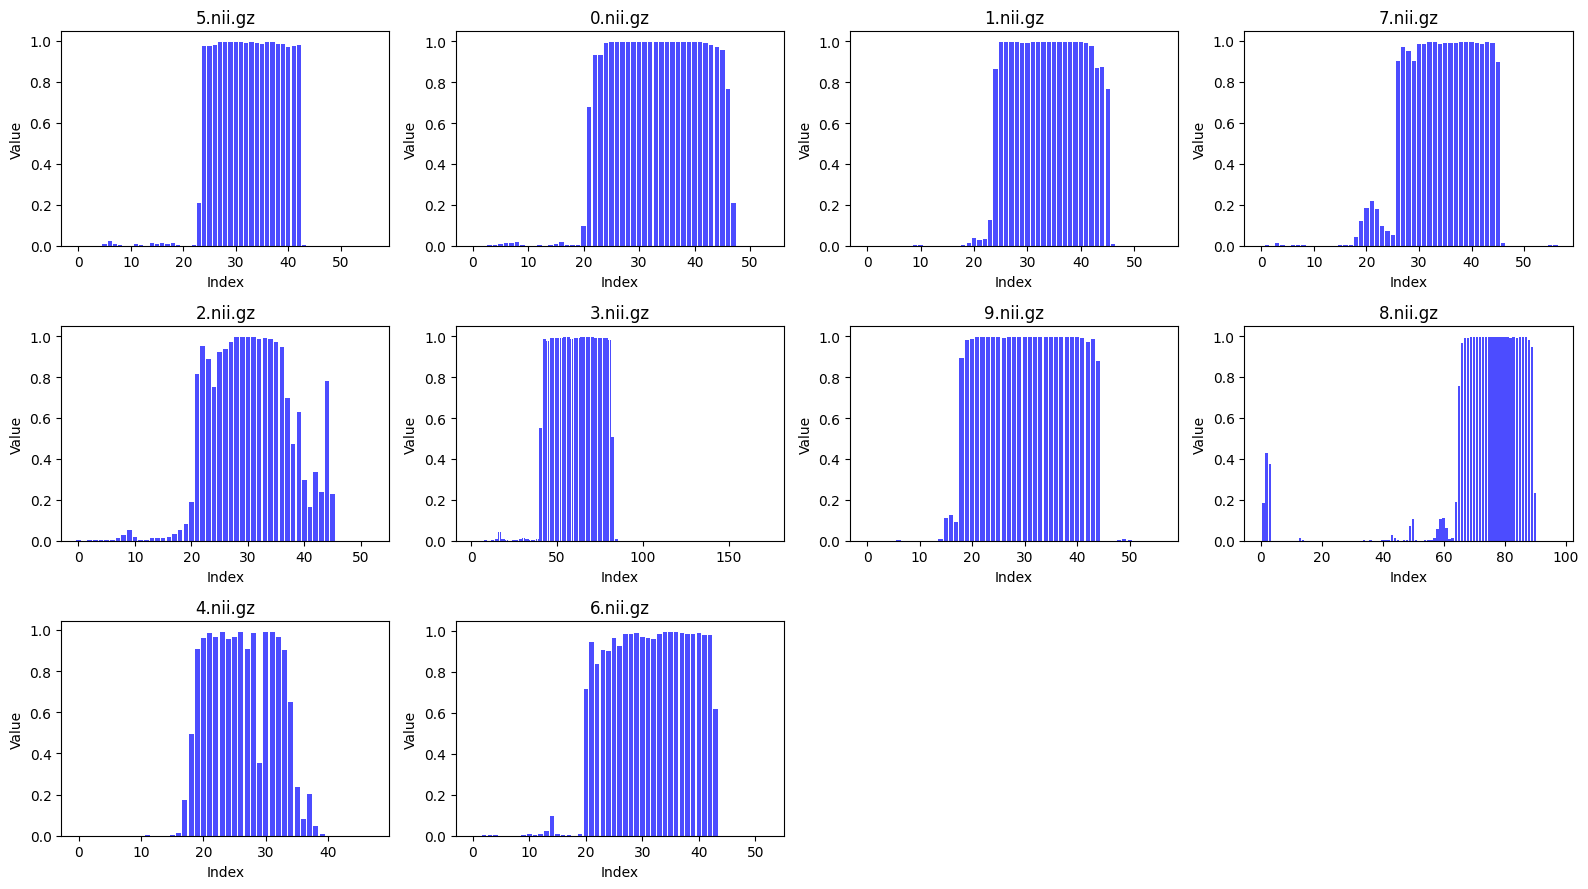

In [30]:
plot_data = [(calculated_outputs[i][0], labeled_scores[calculated_outputs[i][1]][1], labeled_scores[calculated_outputs[i][1]][0], calculated_outputs[i][1]) for i in range(len(calculated_outputs))]
plot_graph(plot_data)